In [1]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk

import warnings
warnings.filterwarnings('ignore')

In [2]:
google_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
print(google_model.most_similar(
	positive=["king", "woman"], 
	negative=["man"]
)[0][0])

print(google_model.most_similar(
	positive=["boy"], 
	negative=["girl"]
)[0][0])

print(google_model.most_similar(
	positive=["actor", "woman"], 
	negative=["boy"]
)[0][0])

print(google_model.most_similar(
	positive=["vehicle", "slow"], 
	negative=["fast"]
)[0][0])

print(google_model.most_similar(
	positive=["fast", "run", "human"]
)[0][0])

queen
boyhood
actress
SUV
running


In [4]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

Summary Statistics for Word Count:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64


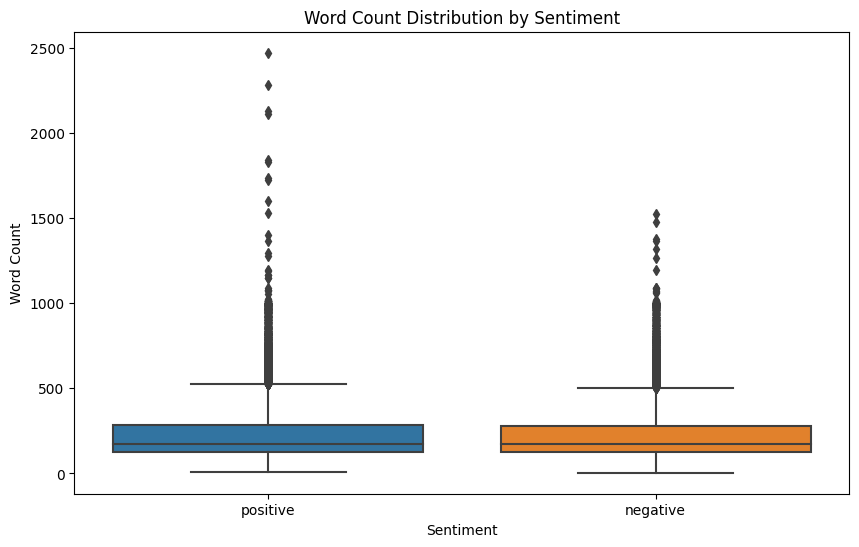

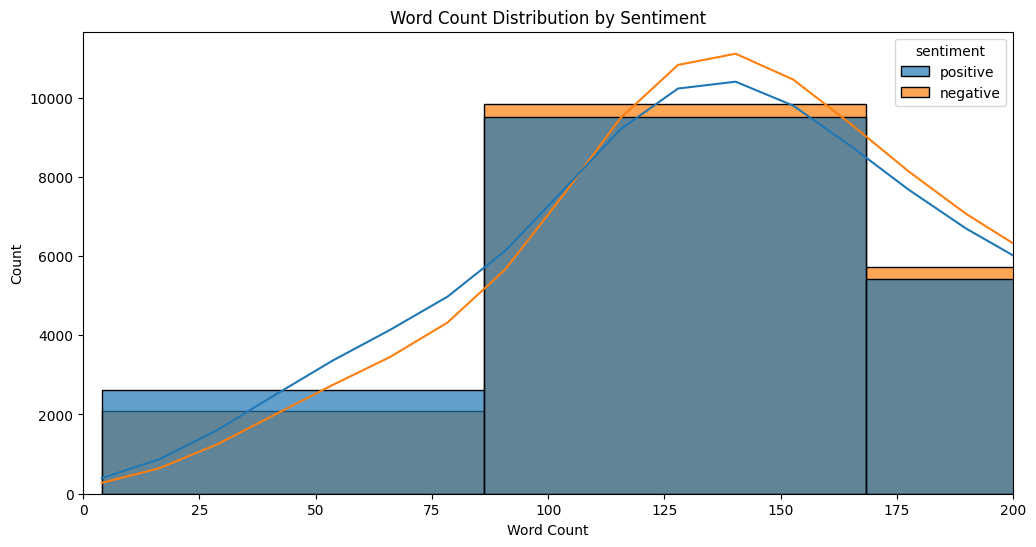

In [6]:
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

print("Summary Statistics for Word Count:")
print(df['word_count'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title('Word Count Distribution by Sentiment')
plt.ylabel('Word Count')
plt.xlabel('Sentiment')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='sentiment', bins=30, alpha=0.7, kde=True)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.xlim(0, 200)
plt.show()

Top 10 Unigrams by Sentiment:


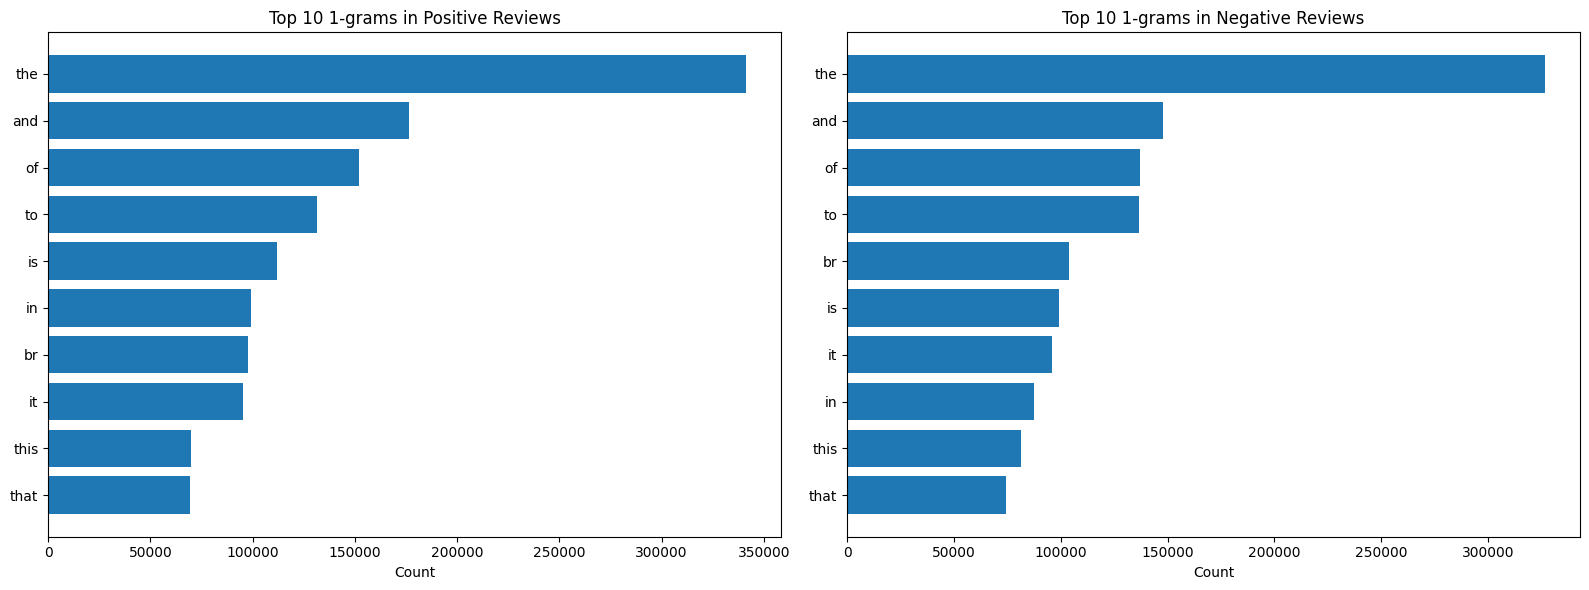

Top 10 Bigrams by Sentiment:


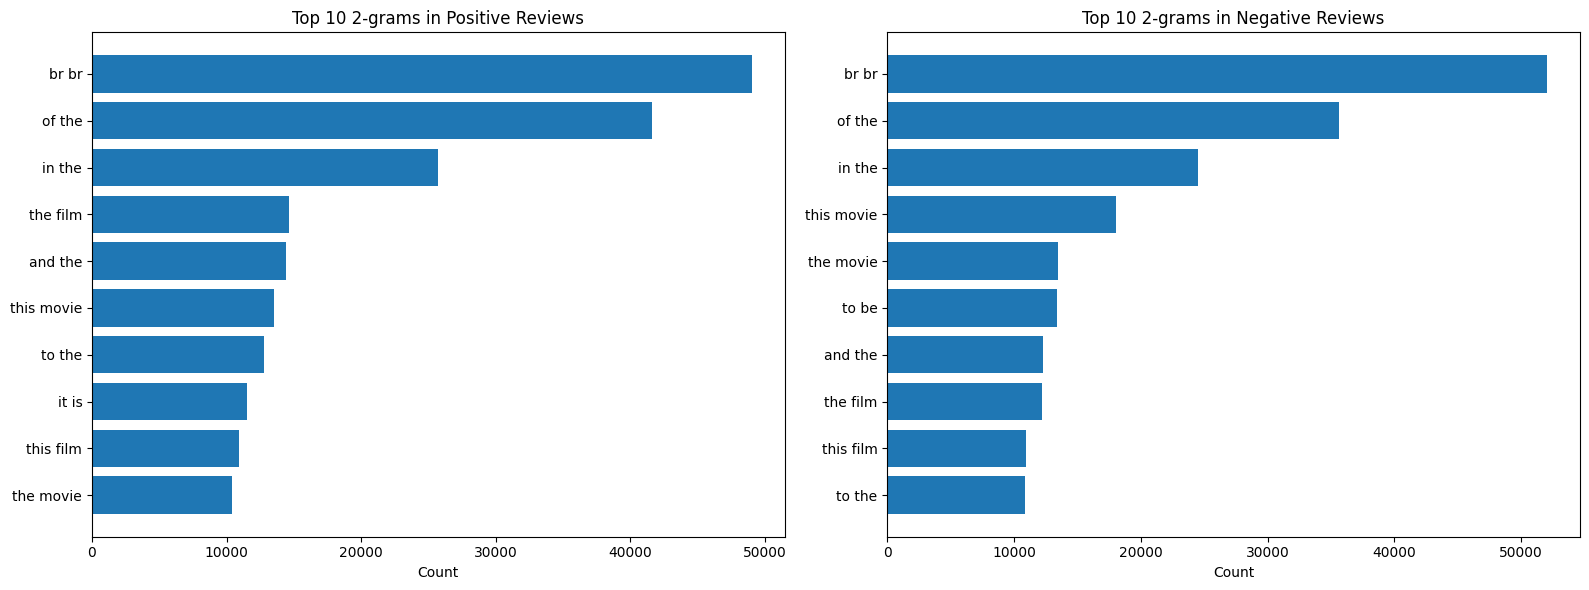

Top 10 Trigrams by Sentiment:


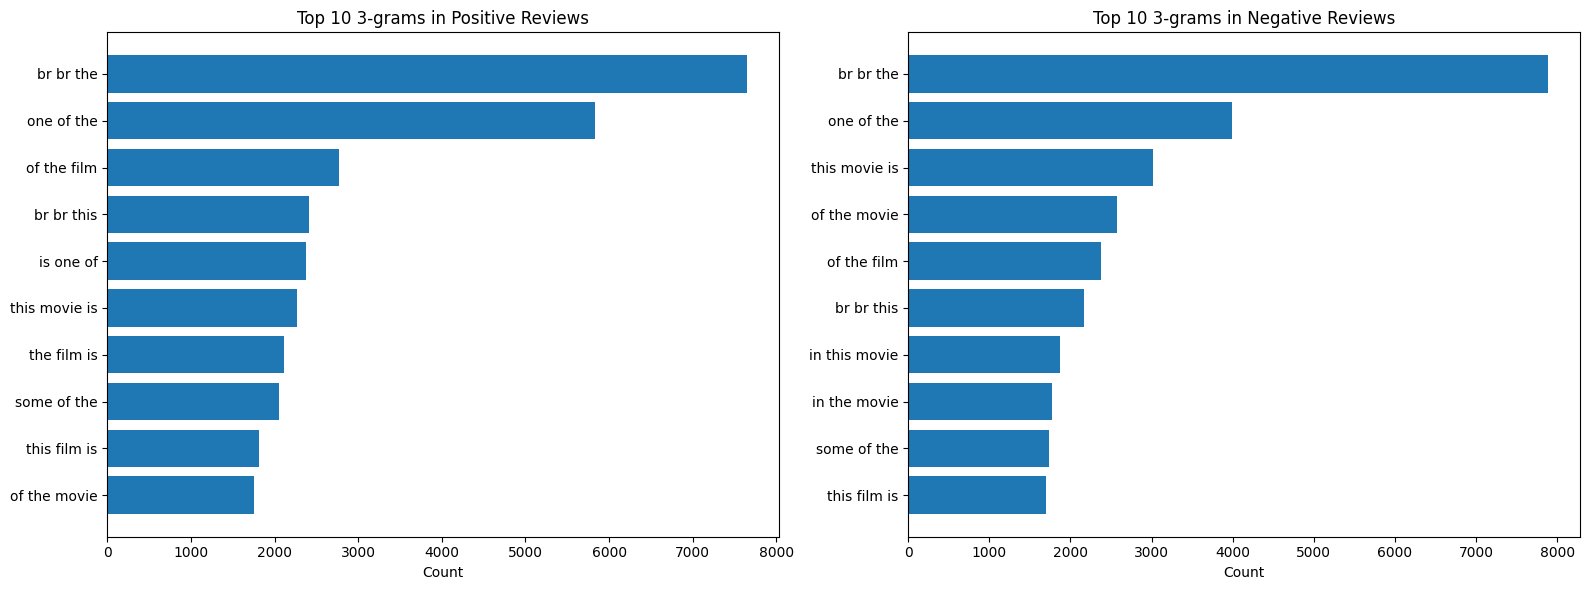

In [7]:
def get_top_ngrams(corpus, n, top_k):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

def plot_top_ngrams(df, n, top_k=10):
    pos_reviews = df[df['sentiment'] == 'positive']['review']
    neg_reviews = df[df['sentiment'] == 'negative']['review']
    
    pos_ngrams = get_top_ngrams(pos_reviews, n, top_k)
    neg_ngrams = get_top_ngrams(neg_reviews, n, top_k)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].barh([x[0] for x in pos_ngrams][::-1], [x[1] for x in pos_ngrams][::-1])
    axes[0].set_title(f'Top {top_k} {n}-grams in Positive Reviews')
    axes[0].set_xlabel('Count')
    
    axes[1].barh([x[0] for x in neg_ngrams][::-1], [x[1] for x in neg_ngrams][::-1])
    axes[1].set_title(f'Top {top_k} {n}-grams in Negative Reviews')
    axes[1].set_xlabel('Count')
    
    plt.tight_layout()
    plt.show()

print("Top 10 Unigrams by Sentiment:")
plot_top_ngrams(df, 1, 10)

print("Top 10 Bigrams by Sentiment:")
plot_top_ngrams(df, 2, 10)

print("Top 10 Trigrams by Sentiment:")
plot_top_ngrams(df, 3, 10)

In [8]:
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    text = text.replace("br", "").replace("<", "").replace(">", "")

    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

df['processed_text'] = df['review'].apply(preprocess_text)

print("Original vs Preprocessed Text:")
for i in range(3):
    print(f"\nOriginal: {df['review'].iloc[i][:100]}...")
    print(f"Processed: {df['processed_text'].iloc[i][:100]}...")

Original vs Preprocessed Text:

Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Processed: one reviewer mentioned watching oz episode youll hooked right exactly happened first thing struck oz...

Original: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B...
Processed: wonderful little production filming technique unassuming oldtimebbc fashion give comforting sometime...

Original: I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air con...
Processed: thought wonderful way spend time hot summer weekend sitting air conditioned theater watching lighthe...


In [9]:
def get_average_word_vector(tokens, wv_model, vector_size=100):
    if hasattr(wv_model, 'wv'):
        vectors = [wv_model.wv[word] for word in tokens if word in wv_model.wv]
    else:
        vectors = [wv_model[word] for word in tokens if word in wv_model]
    
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

In [10]:
df['average_word_vector_google'] = df['processed_text'].apply(lambda x: get_average_word_vector(x.split(), google_model, 300))

X = df['average_word_vector_google'].dropna().tolist()
y = df['sentiment'].dropna().tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

google_classifier = LogisticRegression()
google_classifier.fit(X_train, y_train)

google_y_pred = google_classifier.predict(X_test)

google_accuracy = accuracy_score(y_test, google_y_pred)
print(f"Google News Accuracy: {google_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, google_y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, google_y_pred))

Google News Accuracy: 0.8496
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4961
    positive       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix:
[[4205  756]
 [ 748 4291]]


In [11]:
from gensim.models import Word2Vec
from gensim.models import FastText

sent = df['processed_text'].apply(lambda x: x.split())

In [12]:
sg_model = Word2Vec(sentences=sent, vector_size=100, window=3, min_count=1, sg=1, workers=4)

df['average_word_vector_sg'] = df['processed_text'].apply(lambda x: get_average_word_vector(x.split(), sg_model))

X = df['average_word_vector_sg'].dropna().tolist()
y = df['sentiment'].dropna().tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sg_classifier = LogisticRegression()
sg_classifier.fit(X_train, y_train)

sg_y_pred = sg_classifier.predict(X_test)

sg_accuracy = accuracy_score(y_test, sg_y_pred)
print(f"SG Accuracy: {sg_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, sg_y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, sg_y_pred))

SG Accuracy: 0.8678
Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      4961
    positive       0.87      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
[[4280  681]
 [ 641 4398]]


In [13]:
cbow_model = Word2Vec(sentences=sent, vector_size=100, window=3, min_count=1, sg=0, workers=4)

df['average_word_vector_cbow'] = df['processed_text'].apply(lambda x: get_average_word_vector(x.split(), cbow_model))

X = df['average_word_vector_cbow'].dropna().tolist()
y = df['sentiment'].dropna().tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cbow_classifier = LogisticRegression()
cbow_classifier.fit(X_train, y_train)

cbow_y_pred = cbow_classifier.predict(X_test)

cbow_accuracy = accuracy_score(y_test, cbow_y_pred)
print(f"CBOW Accuracy: {cbow_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, cbow_y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, cbow_y_pred))

CBOW Accuracy: 0.8522
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.85      0.85      4961
    positive       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix:
[[4193  768]
 [ 710 4329]]


In [14]:
ft_model = FastText(sentences=sent, vector_size=100, window=3, min_count=1, sg=1, workers=4)

df['average_word_vector_ft'] = df['processed_text'].apply(lambda x: get_average_word_vector(x.split(), ft_model))

X = df['average_word_vector_ft'].dropna().tolist()
y = df['sentiment'].dropna().tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ft_classifier = LogisticRegression()
ft_classifier.fit(X_train, y_train)

ft_y_pred = ft_classifier.predict(X_test)

ft_accuracy = accuracy_score(y_test, ft_y_pred)
print(f"FastText Accuracy: {ft_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, ft_y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, ft_y_pred))

FastText Accuracy: 0.8667
Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.86      0.86      4961
    positive       0.86      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
[[4259  702]
 [ 631 4408]]
